## DATA AUGMENTATION

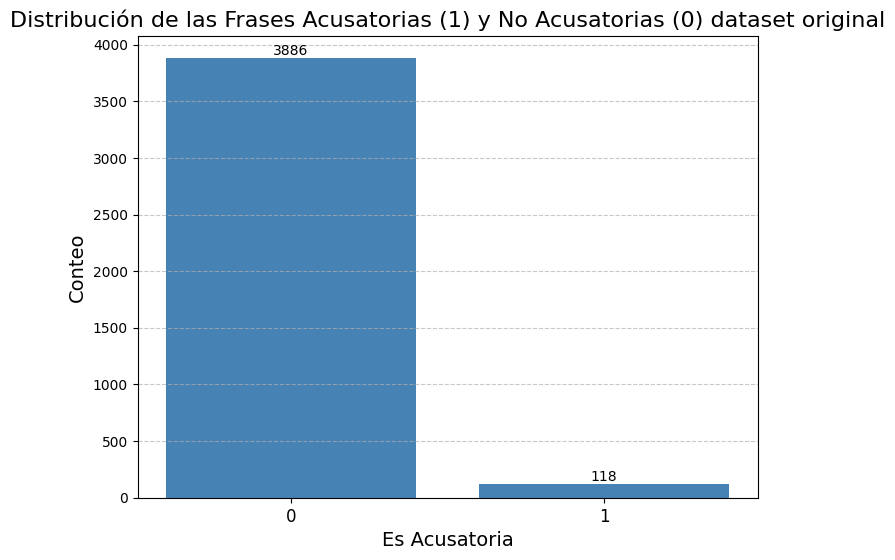

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
# Cargar los archivos CSV (ajusta la ruta a tus archivos)
train_file_path1 = r'DatasetSplited\train_dataset.csv'

# Cargar los datasets
train_data1 = pd.read_csv(train_file_path1)
# Visualizar la distribución de las clases
class_distribution = train_data1['final_pregunta_isAcusatoria'].value_counts()

plt.figure(figsize=(8, 6))
bars = plt.bar(class_distribution.index, class_distribution.values, color='steelblue')
plt.title('Distribución de las Frases Acusatorias (1) y No Acusatorias (0) dataset original', fontsize=16)
plt.xlabel('Es Acusatoria', fontsize=14)
plt.ylabel('Conteo', fontsize=14)
plt.xticks([0, 1], ['0', '1'], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir etiquetas sobre cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()


In [ ]:
### Final Data Aumgentation

!pip install openai tiktoken tqdm

import pandas as pd
import shutil
# Ruta del archivo en Google Drive
file_path = '/content/drive/MyDrive/TESIS/DatasetSplited/train_dataset.csv'
destination = '/content/drive/MyDrive/TESIS/DatasetSplited/train_datasetV2.csv'
# Copiar el archivo
shutil.copyfile(file_path, destination)
# Leer el archivo como un DataFrame de Pandas
datos = pd.read_csv(destination)
datosF = datos[datos['final_pregunta_isAcusatoria'] == 1]
print(len(datosF))
datosF

frasesACU = ""
# Recorrer la lista y concatenar cada elemento con numeración
for i, string in enumerate(datosF["pregunta"].to_list(), 1):
    frasesACU += f"{i}. {string} "

# Imprimir el resultado
print(frasesACU)

ContextWindow = f'''En el contexto de compras públicas del Ecuador, existe un proceso de preguntas que realizan las empresas que desean participar en los concursos. Estas preguntas están
dirigidas a las entidades públicas que están creando el concurso o la necesidad. En esta etapa de preguntas y respuestas, las empresas que desean participar en el proceso realizan comentarios
respecto a dudas en el proceso. Sin embargo, en algunos casos, dichas empresas notan que los procesos están siendo direccionados para que una empresa en particular gane el proceso,
o también, para que solo un tipo de marca o producto en específico pueda cumplir con las especificaciones de la necesidad, lo que causa que el acceso a la participación no sea totalmente libre,
lo cual es ilegal en este tipo de compras en el estado ecuatoriano.

A continuación, te presento una lista de frases extraídas del portal de compras públicas del Ecuador, donde encontrarás frases acusatorias hechas por empresas hacia las entidades públicas.
Tu tarea es generar nuevas frases acusatorias similares a las que te presento, tomando en cuenta las siguientes características:
- Las nuevas frases deben ser originales y no copias directas de las frases de ejemplo ni de las frases generadas anterioermente.
- Las frases deben parecer escritas por una persona real y reflejar preocupaciones específicas sobre la imparcialidad del proceso.
- Las frases acusatorias pueden enfocarse en la especificidad del personal solicitado, la exclusividad de marcas o productos, o cualquier indicio de que el proceso está dirigido a favorecer a un competidor particular.
- Usa un tono formal y profesional apropiado para el contexto de compras públicas.
- No repitas los mismos fabricantes en múltiples frases para asegurar diversidad.

Las frases de ejemplo son: "{frasesACU}"'''

print(ContextWindow)

import openai
import tiktoken

# Asegúrate de tener tiktoken instalado: pip install tiktoken
def CountTokens(messages):
    encoding = tiktoken.get_encoding("o200k_base")  # O usa el modelo que estés utilizando
    total_tokens = len(encoding.encode(ContextWindow))
    return total_tokens

CountTokens(ContextWindow)
print(f"Total tokens usados: {CountTokens(ContextWindow)}")

import pandas as pd
import random
from openai import OpenAI
import concurrent.futures

seed = 42
# Configura la clave de API de OpenAI
api_key = 'xxx xxx xxx'
client = OpenAI(api_key=api_key)
global aux
aux = 0

def generate_new_phrases(context_window, num_phrases=10):
    generated_phrases = []
    global aux
    for _ in range(num_phrases):
        # Configurar la temperatura y el número máximo de tokens de forma aleatoria
        temperature = 0.7  # Puedes ajustar el rango según tus necesidades
        max_tokens = 50   # Incrementar el número máximo de tokens para generar frases completas

        response = client.chat.completions.create(
            model="gpt-4o-mini",
            seed=seed,
            messages=[
                {"role": "system", "content": context_window},
                {"role": "user", "content": '''Genera solo una nueva frase acusatoria completa pero corta sin repetir nombres de fabricantes mencionados anteriormente, instituciones o empresas.
                Que no se parezca en nada a las frases nuevas acusatorias, DE INICIO A FIN. Algunas frases hazlas más informales, las frases deben iniciar de manera diferente
                toma como ejemplo las frases del contexto inicial'''}
            ],
            temperature=temperature,
            max_tokens=max_tokens,
            stop=["NUEVA FRASE ACUSATORIA:"]  # Señal de parada para garantizar la frase completa
        )
        generated_text = response.choices[0].message.content.strip()
        generated_phrases.append(generated_text)
        # Actualizar la ventana de contexto con las nuevas frases generadas
        context_window = context_window + "\n" + "NUEVA FRASE ACUSATORIA: " + generated_text + "\n"
        print(generated_text)
        aux += 1
        print(aux)
    return generated_phrases

# Genera las nuevas frases acusatorias
new_phrases = []
num_phrases_to_generate = 2500
num_phrases_per_iteration = 2500  # Número de frases a generar en cada iteración

# Executor para manejar el timeout
with concurrent.futures.ThreadPoolExecutor() as executor:
    while len(new_phrases) < num_phrases_to_generate:
        # Usamos submit para ejecutar generate_new_phrases en un hilo separado
        future = executor.submit(generate_new_phrases, ContextWindow, num_phrases=num_phrases_per_iteration)

        try:
            # Obtener resultados con timeout de 60 segundos
            result = future.result(timeout=60)
            new_phrases.extend(result)
            print(result)
        except concurrent.futures.TimeoutError:
            print(f"Timeout occurred - moving to next iteration.")
        except Exception as e:
            print(f"An error occurred: {str(e)}")

# Verificar que se generaron exactamente 2500 frases
if len(new_phrases) > num_phrases_to_generate:
    new_phrases = new_phrases[:num_phrases_to_generate]

# Convertir new_phrases en un DataFrame y guardarlo
new_phrases_df = pd.DataFrame(new_phrases, columns=["generated_phrase"])
new_phrases_df.to_csv("new_accusatory_phrases.csv", index=False)
print("Generated phrases saved to new_accusatory_phrases.csv")


# Convertir new_phrases en un DataFrame y guardarlo
new_phrases_df = pd.DataFrame(new_phrases, columns=["generated_phrase"])
new_phrases_df.to_csv("new_accusatory_phrases.csv", index=False)
print("Generated phrases saved to new_accusatory_phrases.csv")

import pandas as pd
import random
from openai import OpenAI
import concurrent.futures

seed = 42
# Configura la clave de API de OpenAI
api_key = 'api-key
client = OpenAI(api_key=api_key)
global aux
aux = 0

def generate_new_phrases(context_window, num_phrases=10):
    generated_phrases = []
    global aux
    for _ in range(num_phrases):
        # Configurar la temperatura y el número máximo de tokens de forma aleatoria
        temperature = 0.7  # Puedes ajustar el rango según tus necesidades
        max_tokens = 50   # Incrementar el número máximo de tokens para generar frases completas

        response = client.chat.completions.create(
            model="gpt-4o-mini",
            seed=seed+aux,
            messages=[
                {"role": "system", "content": context_window},
                {"role": "user", "content": '''Genera solo una nueva frase acusatoria completa pero corta, menciona a fabricantes o productos en especifico, instituciones o empresas.
                Que no se parezca en nada a las frases nuevas acusatorias, DE INICIO A FIN. Algunas frases hazlas más informales, las frases deben iniciar de manera diferente
                toma como ejemplo las frases del contexto inicial'''}
            ],
            temperature=temperature,
            max_tokens=max_tokens,
            stop=["NUEVA FRASE ACUSATORIA:"]  # Señal de parada para garantizar la frase completa
        )
        generated_text = response.choices[0].message.content.strip()
        generated_phrases.append(generated_text)
        # Actualizar la ventana de contexto con las nuevas frases generadas
        #context_window = context_window + "\n" + "NUEVA FRASE ACUSATORIA: " + generated_text + "\n"
        print(generated_text)
        aux += 1
        print(aux)
    return generated_phrases

# Genera las nuevas frases acusatorias
num_phrases_to_generate = 2500

new_phrases=generate_new_phrases(ContextWindow, num_phrases=num_phrases_to_generate)

# Verificar que se generaron exactamente 2500 frases
if len(new_phrases) > num_phrases_to_generate:
    new_phrases = new_phrases[:num_phrases_to_generate]

# Convertir new_phrases en un DataFrame y guardarlo
new_phrases_df = pd.DataFrame(new_phrases, columns=["generated_phrase"])
new_phrases_df.to_csv("new_accusatory_phrases2.csv", index=False)

print("Generated phrases saved to new_accusatory_phrases2.csv")

import pandas as pd
import shutil
# Ruta del archivo en Google Drive
file_path = '/content/drive/MyDrive/TESIS/DatasetSplited/new_accusatory_phrases2.csv'
# Leer el archivo como un DataFrame de Pandas
datos = pd.read_csv(file_path)
datos

# Crear un nuevo DataFrame con las columnas deseadas
start_id = 43
new_data = {
    'contract_id': range(start_id, start_id + len(datos["generated_phrase"])),
    'pregunta_id': range(start_id, start_id + len(datos["generated_phrase"])),
    'pregunta': datos['generated_phrase'],
    'sum_pregunta_isAcusatoria': [3] * len(datos),
    'final_pregunta_isAcusatoria': [1] * len(datos)
}

df_new = pd.DataFrame(new_data)

# Mostrar las primeras filas del nuevo DataFrame
df_new

# Leer el archivo de texto que contiene las frases
file_path = '/content/drive/MyDrive/TESIS/DatasetSplited/dataset1.txt'

# Leer el contenido del archivo de texto
with open(file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Filtrar las líneas, omitiendo las vacías, las que contienen "Timeout occurred" y los números
phrases = [line.strip().strip('"') for line in lines if line.strip() and "Timeout occurred" not in line and not line.strip().isdigit()]

# Crear un nuevo DataFrame con las frases extraídas
df_new_phrases = pd.DataFrame({
    'contract_id': [42] * len(phrases),
    'pregunta_id': [42] * len(phrases),
    'pregunta': phrases,
    'sum_pregunta_isAcusatoria': [3] * len(phrases),
    'final_pregunta_isAcusatoria': [1] * len(phrases)
})
df_new_phrases


# Combinar el nuevo DataFrame con el DataFrame existente
df_combined = pd.concat([df_new, df_new_phrases], ignore_index=True)

# Mostrar el DataFrame combinado
df_combined


import pandas as pd
import shutil
# Ruta del archivo en Google Drive
file_path = '/content/drive/MyDrive/TESIS/DatasetSplited/train_dataset.csv'
# Leer el archivo como un DataFrame de Pandas
datos2 = pd.read_csv(file_path)
datos2

# Combinar el nuevo DataFrame con el DataFrame existente
df_combinedF = pd.concat([datos2, df_combined], ignore_index=True)

# Mostrar el DataFrame combinado
# Definir una función para eliminar comillas al inicio y al final de una frase
def remove_quotes(phrase):
    return phrase.strip('"')

# Aplicar la función a la columna 'pregunta' del DataFrame
df_combined['pregunta'] = df_combined['pregunta'].apply(remove_quotes)
df_combined['pregunta'] = df_combined['pregunta'].apply(remove_quotes)

df_combinedF.to_csv("/content/drive/MyDrive/TESIS/DatasetSplited/train_datasetAUG.csv", index=False)

df_combinedF

## PREPROCESAMIENTO DEL DATASET

In [14]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Cargar los archivos CSV (ajusta la ruta a tus archivos)
train_file_path = r'DatasetSplited\train_datasetAUG_COPY.csv'
test_file_path = r'DatasetSplited\test_dataset.csv'

# Cargar los datasets
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Verificar que el archivo se ha cargado correctamente
print(train_data.head())

# Descargar recursos de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocesamiento del texto
stop_words = set(stopwords.words('spanish'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(stemmer.stem(word)) for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

# Aplicar el preprocesamiento al dataset de entrenamiento
train_data['tokens'] = train_data['pregunta'].apply(preprocess_text)
test_data['tokens'] = test_data['pregunta'].apply(preprocess_text)


   contract_id  pregunta_id  \
0      1641562      1174809   
1      1587612       500621   
2      1439639      1578459   
3       936351       266462   
4      1489360        95182   

                                            pregunta  \
0  Favor especificar el alcance de la capacitació...   
1  Señores se dará preferencia a que el servicio ...   
2  La tarea solicitada: "Realizar las tareas de p...   
3  Estimada entidad...ustedes entregaria los arte...   
4  LOS PERMISOS DE HORARIOS ROTATIVOS EL MINISTER...   

   sum_pregunta_isAcusatoria  final_pregunta_isAcusatoria  
0                          0                            0  
1                          0                            0  
2                          0                            0  
3                          0                            0  
4                          0                            0  


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bpnab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bpnab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bpnab\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
# Construir vocabulario a partir del dataset de entrenamiento
word_counts = Counter(word for tokens in train_data['tokens'] for word in tokens)
vocab = {word: i+1 for i, word in enumerate(word_counts)}

# Función para convertir tokens a índices
def tokens_to_indices(tokens):
    return [vocab.get(token, 0) for token in tokens]

# Convertir los tokens en índices
train_data['indexed_tokens'] = train_data['tokens'].apply(tokens_to_indices)
test_data['indexed_tokens'] = test_data['tokens'].apply(tokens_to_indices)

# Verificar la conversión
print(train_data[['pregunta', 'tokens', 'indexed_tokens']].head())


                                            pregunta  \
0  Favor especificar el alcance de la capacitació...   
1  Señores se dará preferencia a que el servicio ...   
2  La tarea solicitada: "Realizar las tareas de p...   
3  Estimada entidad...ustedes entregaria los arte...   
4  LOS PERMISOS DE HORARIOS ROTATIVOS EL MINISTER...   

                                              tokens  \
0  [favor, especificar, alcanc, capacitación, pue...   
1  [señor, dará, preferencia, servicio, otorgado,...   
2  [tarea, solicitada, realizar, tarea, provisión...   
3  [estimada, entidad, usted, entregaria, art, ca...   
4  [permiso, horario, rotativo, ministerio, traba...   

                                      indexed_tokens  
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  
1  [20, 21, 22, 23, 24, 6, 25, 26, 27, 28, 29, 30...  
2  [42, 43, 44, 42, 45, 46, 47, 8, 48, 49, 50, 51...  
3                       [62, 63, 64, 65, 66, 67, 68]  
4  [69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 8..

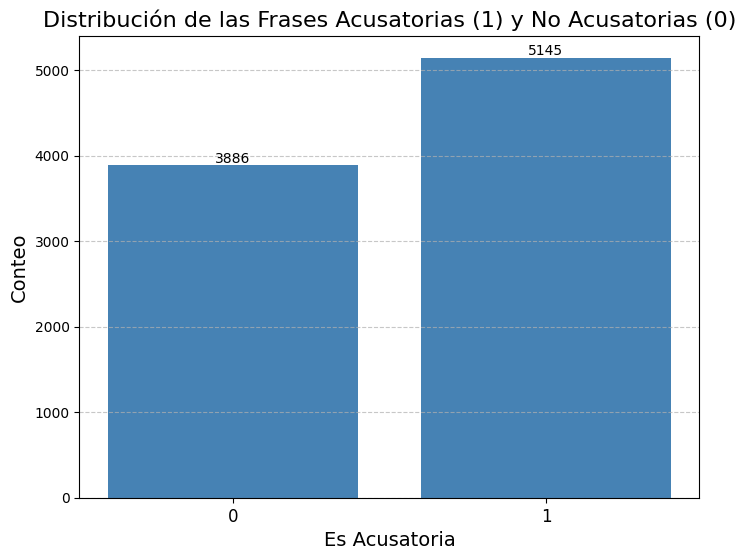

In [16]:
# Visualizar la distribución de las clases
class_distribution = train_data['final_pregunta_isAcusatoria'].value_counts()

plt.figure(figsize=(8, 6))
bars = plt.bar(class_distribution.index, class_distribution.values, color='steelblue')
plt.title('Distribución de las Frases Acusatorias (1) y No Acusatorias (0)', fontsize=16)
plt.xlabel('Es Acusatoria', fontsize=14)
plt.ylabel('Conteo', fontsize=14)
plt.xticks([0, 1], ['0', '1'], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir etiquetas sobre cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()


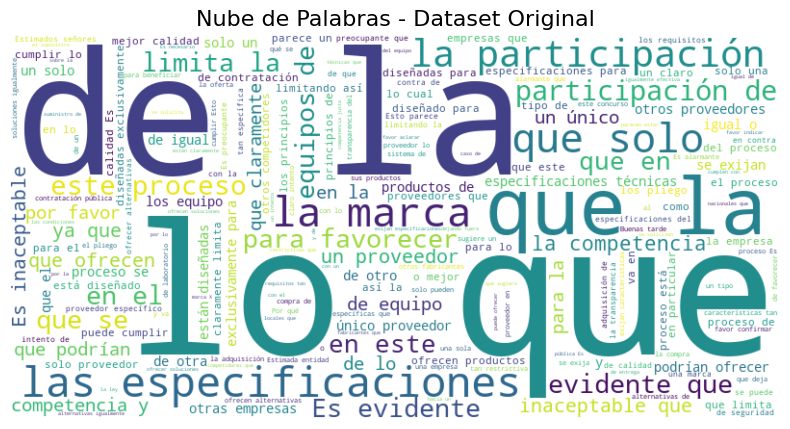

In [17]:
# Nube de palabras del dataset original
all_text = ' '.join(train_data['pregunta'].astype(str).tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - Dataset Original', fontsize=16)
plt.show()


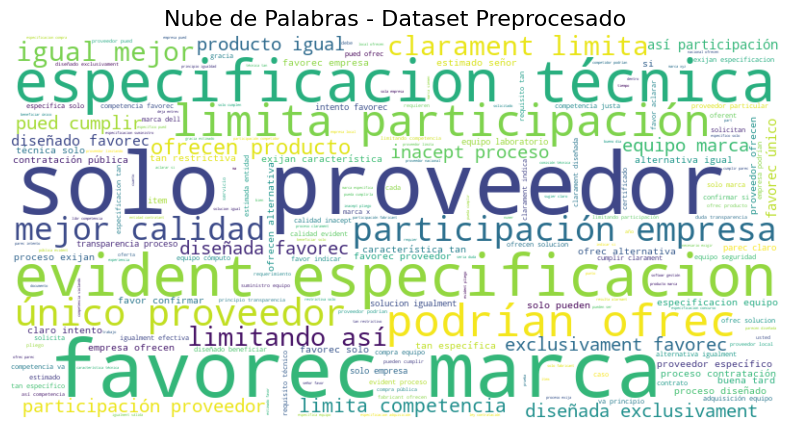

In [18]:
# Nube de palabras del dataset preprocesado
all_processed_text = ' '.join([' '.join(tokens) for tokens in train_data['tokens']])

wordcloud_preprocessed = WordCloud(width=800, height=400, background_color='white').generate(all_processed_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_preprocessed, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - Dataset Preprocesado', fontsize=16)
plt.show()


## ENTRENAMIENTO

### RNN

In [37]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# Clase personalizada para el Dataset
class SentimentDataset(Dataset):
    def __init__(self, dataframe):
        self.inputs = dataframe['indexed_tokens'].tolist()
        self.labels = dataframe['final_pregunta_isAcusatoria'].tolist()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

# Función para rellenar secuencias en batch
def collate_fn(batch):
    inputs, labels = zip(*batch)
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    return inputs_padded, labels_tensor

# Crear datasets y DataLoaders
train_dataset = SentimentDataset(train_data)
test_dataset = SentimentDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)


In [38]:
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy

# Definir la red RNN para el análisis de sentimientos
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        output = output[:, -1, :]  # Tomar la última salida de la secuencia
        return self.fc(output)

# Función para entrenar el modelo
def train_model(model, train_loader, optimizer, criterion, device, num_epochs):
    model.train()
    history_loss = []
    history_accuracy = []
    
    for epoch in range(num_epochs):
        total_loss = 0
        total_correct = 0
        total_examples = 0
        accuracy_metric = MulticlassAccuracy(num_classes=2, average='macro').to(device)

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            predictions = model(inputs)
            loss = criterion(predictions, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += accuracy_metric(predictions, labels)
            total_examples += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        avg_accuracy = total_correct / len(train_loader)
        history_loss.append(avg_loss)
        history_accuracy.append(avg_accuracy.item())

        print(f"Epoch {epoch+1}/{num_epochs}: Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}")

    return history_loss, history_accuracy

# Inicializar el modelo
vocab_size = len(vocab) + 1
model = SentimentRNN(vocab_size, embedding_dim=100, hidden_dim=128, output_dim=2)

# Mover el modelo a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir el optimizador y la función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Entrenar el modelo
num_epochs = 50
history_loss, history_accuracy = train_model(model, train_loader, optimizer, criterion, device, num_epochs)


Epoch 1/50: Loss: 0.6813, Accuracy: 0.5122
Epoch 2/50: Loss: 0.6814, Accuracy: 0.5117
Epoch 3/50: Loss: 0.6796, Accuracy: 0.5149
Epoch 4/50: Loss: 0.6788, Accuracy: 0.5140
Epoch 5/50: Loss: 0.6782, Accuracy: 0.5147
Epoch 6/50: Loss: 0.6792, Accuracy: 0.5155
Epoch 7/50: Loss: 0.6760, Accuracy: 0.5203
Epoch 8/50: Loss: 0.6766, Accuracy: 0.5156
Epoch 9/50: Loss: 0.6767, Accuracy: 0.5167
Epoch 10/50: Loss: 0.6771, Accuracy: 0.5152
Epoch 11/50: Loss: 0.6748, Accuracy: 0.5162
Epoch 12/50: Loss: 0.6753, Accuracy: 0.5155
Epoch 13/50: Loss: 0.6744, Accuracy: 0.5186
Epoch 14/50: Loss: 0.6733, Accuracy: 0.5171
Epoch 15/50: Loss: 0.6732, Accuracy: 0.5198
Epoch 16/50: Loss: 0.6866, Accuracy: 0.5213
Epoch 17/50: Loss: 0.7334, Accuracy: 0.5010
Epoch 18/50: Loss: 0.7105, Accuracy: 0.5336
Epoch 19/50: Loss: 0.7073, Accuracy: 0.4925
Epoch 20/50: Loss: 0.7089, Accuracy: 0.5055
Epoch 21/50: Loss: 0.7081, Accuracy: 0.4984
Epoch 22/50: Loss: 0.7071, Accuracy: 0.4782
Epoch 23/50: Loss: 0.6963, Accuracy: 0.50

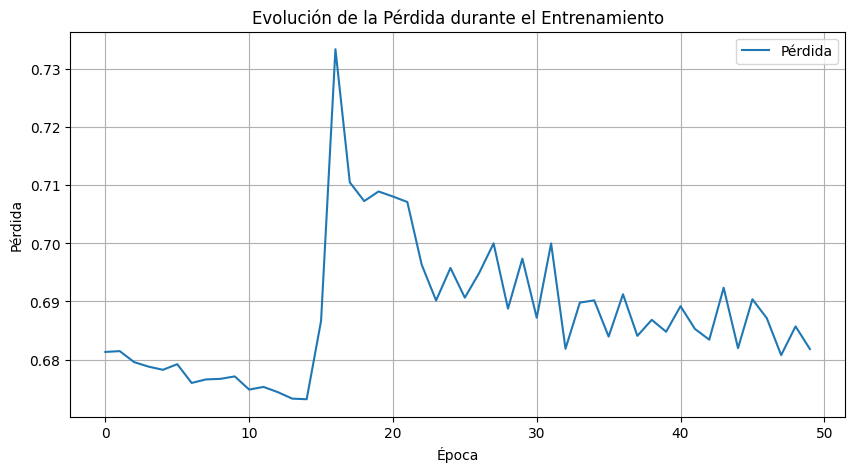

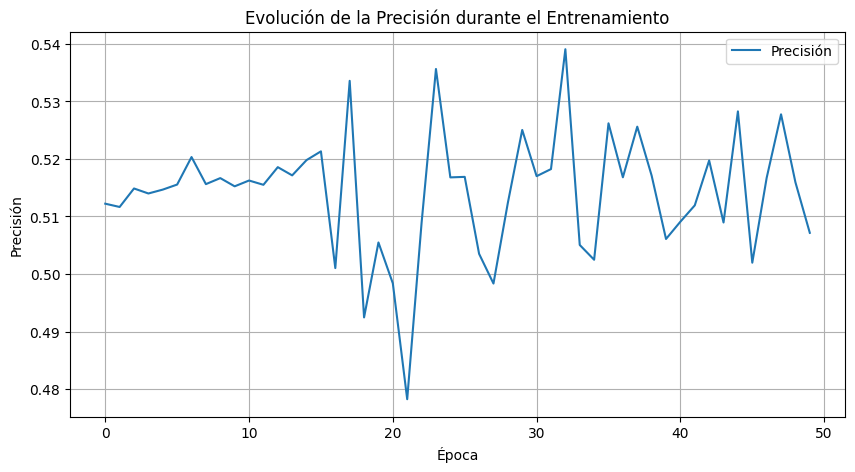

In [39]:
# Graficar la pérdida a lo largo de las épocas
plt.figure(figsize=(10,5))
plt.plot(history_loss, label='Pérdida')
plt.title('Evolución de la Pérdida durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()
plt.show()

# Graficar la precisión a lo largo de las épocas
plt.figure(figsize=(10,5))
plt.plot(history_accuracy, label='Precisión')
plt.title('Evolución de la Precisión durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid()
plt.show()


Reporte de Clasificación:
                   precision    recall  f1-score   support

No Acusatoria (0)       0.98      0.22      0.36       972
   Acusatoria (1)       0.03      0.83      0.06        29

         accuracy                           0.24      1001
        macro avg       0.50      0.52      0.21      1001
     weighted avg       0.95      0.24      0.35      1001

Matriz de Confusión:
[[214 758]
 [  5  24]]
Matriz de Confusión en Porcentajes:
[[22.01646091 77.98353909]
 [17.24137931 82.75862069]]


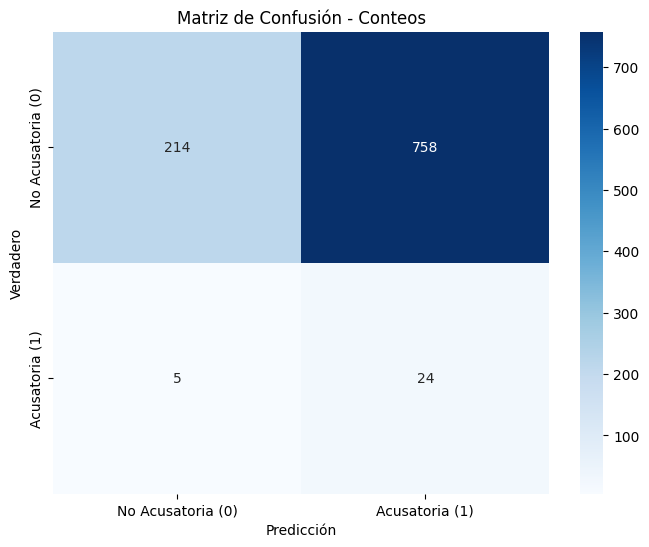

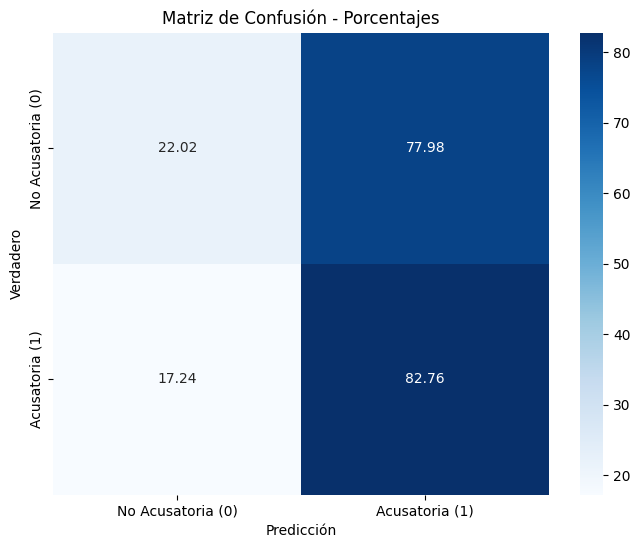

In [43]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Definir la función para generar predicciones en el conjunto de prueba
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            _, predicted_labels = torch.max(predictions, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted_labels.cpu().numpy())
    
    return np.array(y_true), np.array(y_pred)

# Obtener las predicciones y etiquetas verdaderas
y_true, y_pred = evaluate_model(model, test_loader, device)

# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=['No Acusatoria (0)', 'Acusatoria (1)']))

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)

# Matriz de confusión en porcentajes
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
print("Matriz de Confusión en Porcentajes:")
print(conf_matrix_percent)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Acusatoria (0)', 'Acusatoria (1)'], yticklabels=['No Acusatoria (0)', 'Acusatoria (1)'])
plt.title('Matriz de Confusión - Conteos')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

# Graficar la matriz de confusión en porcentajes
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=['No Acusatoria (0)', 'Acusatoria (1)'], yticklabels=['No Acusatoria (0)', 'Acusatoria (1)'])
plt.title('Matriz de Confusión - Porcentajes')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()


In [50]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Definir la función para generar predicciones en el conjunto de prueba y probabilidades
def evaluate_model(model, test_loader, device):
    model.eval()  # Poner el modelo en modo evaluación
    y_true = []
    y_pred_prob = []
    
    with torch.no_grad():  # No necesitamos calcular gradientes en modo evaluación
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)  # Obtener logits
            probabilities = torch.softmax(predictions, dim=1)  # Convertir logits en probabilidades
            y_pred_prob.extend(probabilities.cpu().numpy())  # Guardar las probabilidades para ambas clases
            y_true.extend(labels.cpu().numpy())  # Guardar las etiquetas verdaderas
    
    return np.array(y_true), np.array(y_pred_prob)

# Llama a la función para obtener etiquetas y probabilidades
y_true, y_pred_prob = evaluate_model(model, test_loader, device)

# A partir de aquí, y_pred_prob contiene las probabilidades de ambas clases


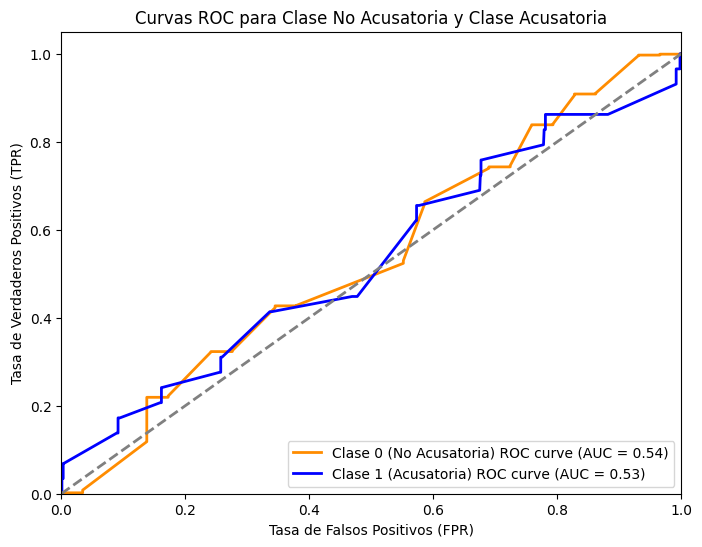

In [51]:
# Calcular la curva ROC para cada clase
fpr = {}
tpr = {}
roc_auc = {}

# Calcular ROC y AUC para la clase 0 (No Acusatoria)
fpr[0], tpr[0], _ = roc_curve(y_true, y_pred_prob[:, 0], pos_label=0)  # Probabilidades para la clase 0
roc_auc[0] = auc(fpr[0], tpr[0])

# Calcular ROC y AUC para la clase 1 (Acusatoria)
fpr[1], tpr[1], _ = roc_curve(y_true, y_pred_prob[:, 1], pos_label=1)  # Probabilidades para la clase 1
roc_auc[1] = auc(fpr[1], tpr[1])

# Graficar la curva ROC para ambas clases
plt.figure(figsize=(8, 6))

# Curva ROC para la clase 0 (No Acusatoria)
plt.plot(fpr[0], tpr[0], color='darkorange', lw=2, label='Clase 0 (No Acusatoria) ROC curve (AUC = %0.2f)' % roc_auc[0])

# Curva ROC para la clase 1 (Acusatoria)
plt.plot(fpr[1], tpr[1], color='blue', lw=2, label='Clase 1 (Acusatoria) ROC curve (AUC = %0.2f)' % roc_auc[1])

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Línea base
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC para Clase No Acusatoria y Clase Acusatoria')
plt.legend(loc="lower right")
plt.show()


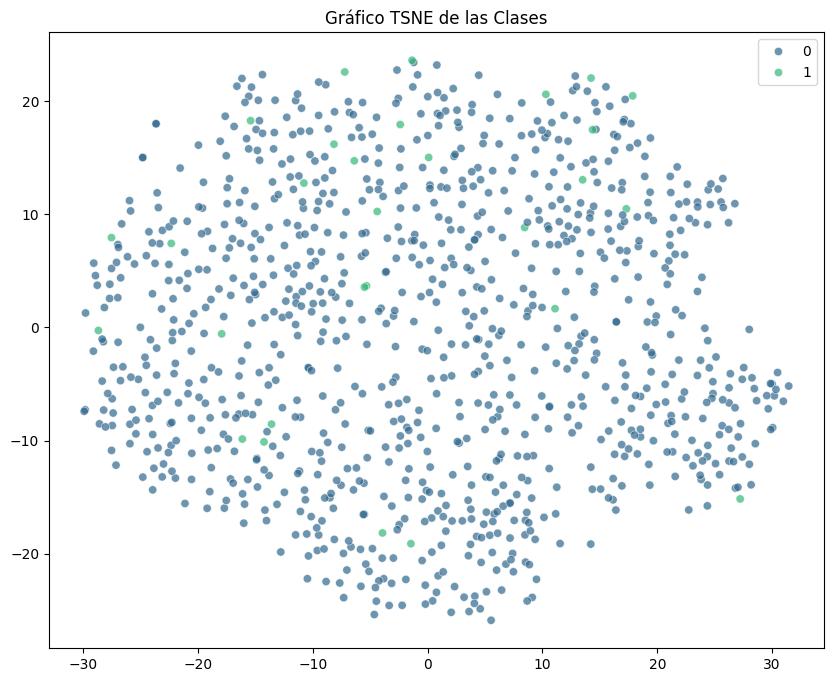

In [34]:
# Modificar la función para extraer características
def extract_features(model, loader, device):
    model.eval()
    features = []
    labels = []
    
    with torch.no_grad():
        for inputs, label in loader:
            inputs = inputs.to(device)
            
            # Extraer embeddings a partir del RNN (no solo embeddings iniciales)
            outputs = model.embedding(inputs)  # Primero extraer el embedding
            rnn_output, _ = model.rnn(outputs)  # Pasar por la RNN
            
            # Tomar el promedio de los outputs a lo largo de la secuencia (dimensión 1)
            rnn_output_mean = torch.mean(rnn_output, dim=1)
            
            features.extend(rnn_output_mean.cpu().numpy())
            labels.extend(label.numpy())
    
    return np.array(features), np.array(labels)

# Extraer los embeddings del conjunto de prueba
features, labels = extract_features(model, test_loader, device)

# Aplicar TSNE para reducir las dimensiones a 2D
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features)

# Graficar TSNE
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette='viridis', legend='full', alpha=0.7)
plt.title('Gráfico TSNE de las Clases')
plt.show()


### LSTM

Epoch 1/50: Loss: 0.6818, Accuracy: 0.5124
Epoch 2/50: Loss: 0.5053, Accuracy: 0.7058
Epoch 3/50: Loss: 0.2706, Accuracy: 0.9189
Epoch 4/50: Loss: 0.2571, Accuracy: 0.9191
Epoch 5/50: Loss: 0.1953, Accuracy: 0.9447
Epoch 6/50: Loss: 0.2039, Accuracy: 0.9400
Epoch 7/50: Loss: 0.1925, Accuracy: 0.9458
Epoch 8/50: Loss: 0.3144, Accuracy: 0.9056
Epoch 9/50: Loss: 0.2962, Accuracy: 0.9076
Epoch 10/50: Loss: 0.4249, Accuracy: 0.8442
Epoch 11/50: Loss: 0.4309, Accuracy: 0.8382
Epoch 12/50: Loss: 0.3895, Accuracy: 0.8639
Epoch 13/50: Loss: 0.3503, Accuracy: 0.8863
Epoch 14/50: Loss: 0.3431, Accuracy: 0.8905
Epoch 15/50: Loss: 0.3429, Accuracy: 0.8897
Epoch 16/50: Loss: 0.3252, Accuracy: 0.8987
Epoch 17/50: Loss: 0.3164, Accuracy: 0.9031
Epoch 18/50: Loss: 0.3073, Accuracy: 0.9078
Epoch 19/50: Loss: 0.3125, Accuracy: 0.9038
Epoch 20/50: Loss: 0.3335, Accuracy: 0.8862
Epoch 21/50: Loss: 0.3452, Accuracy: 0.8770
Epoch 22/50: Loss: 0.3623, Accuracy: 0.8649
Epoch 23/50: Loss: 0.3262, Accuracy: 0.88

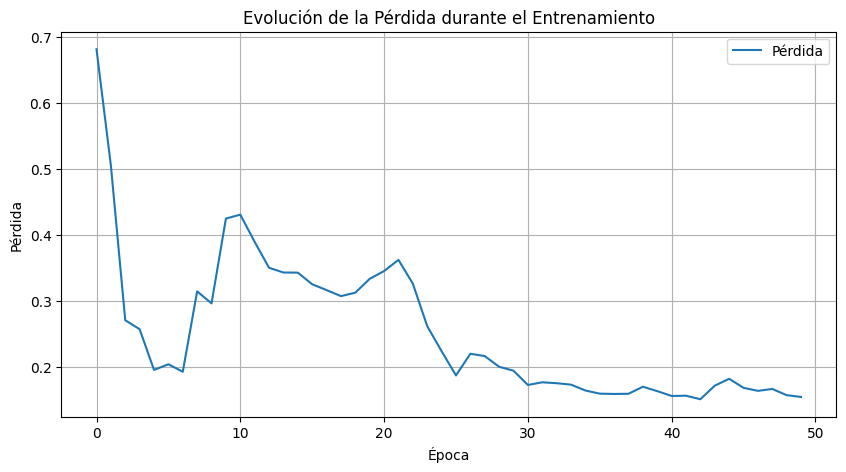

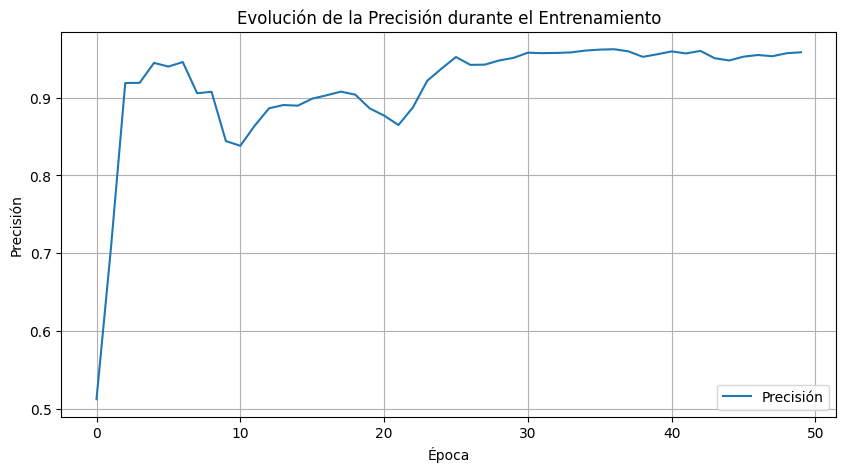

Reporte de Clasificación:
                   precision    recall  f1-score   support

No Acusatoria (0)       0.97      0.91      0.94       972
   Acusatoria (1)       0.06      0.21      0.09        29

         accuracy                           0.89      1001
        macro avg       0.52      0.56      0.52      1001
     weighted avg       0.95      0.89      0.91      1001

Matriz de Confusión:
[[880  92]
 [ 23   6]]
Matriz de Confusión en Porcentajes:
[[90.53497942  9.46502058]
 [79.31034483 20.68965517]]


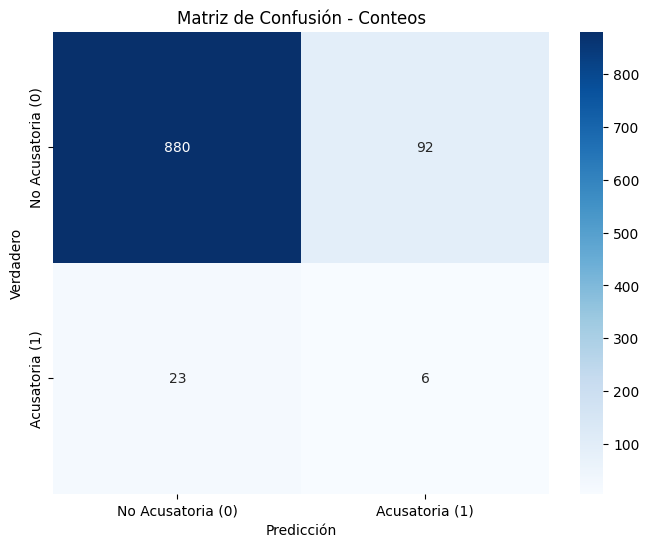

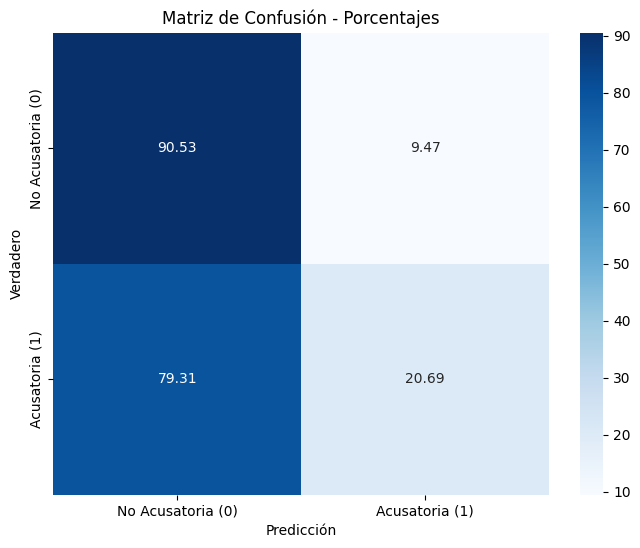

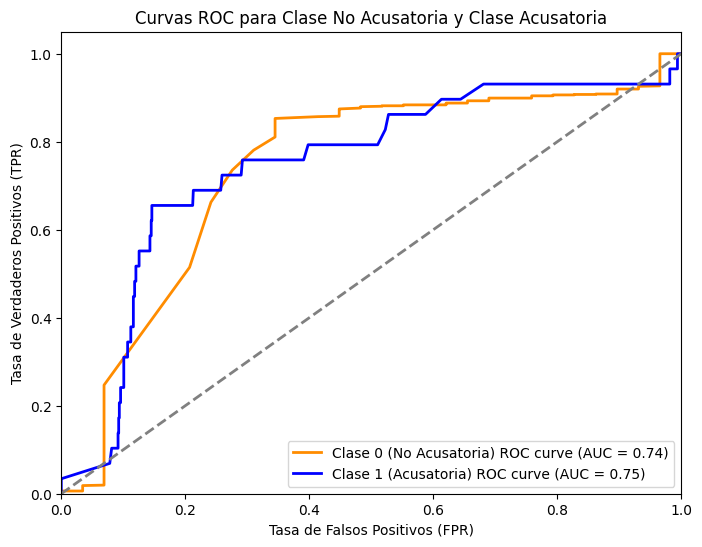

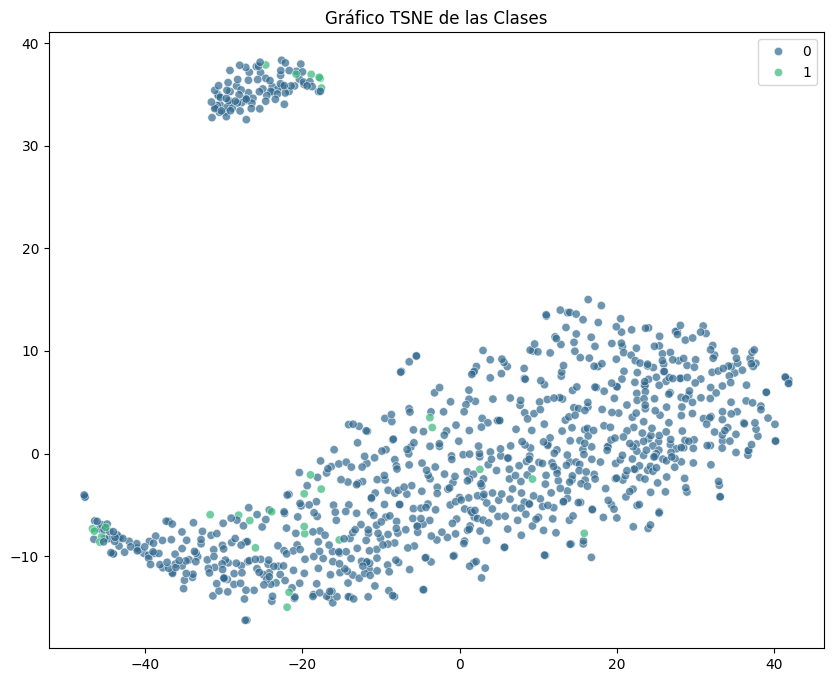

In [52]:
### LSTM
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# Clase personalizada para el Dataset
class SentimentDataset(Dataset):
    def __init__(self, dataframe):
        self.inputs = dataframe['indexed_tokens'].tolist()
        self.labels = dataframe['final_pregunta_isAcusatoria'].tolist()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

# Función para rellenar secuencias en batch
def collate_fn(batch):
    inputs, labels = zip(*batch)
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    return inputs_padded, labels_tensor

# Crear datasets y DataLoaders
train_dataset = SentimentDataset(train_data)
test_dataset = SentimentDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)

import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy

# Definir la red LSTM para el análisis de sentimientos
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        output = output[:, -1, :]  # Tomar la última salida de la secuencia
        return self.fc(output)

# Función para entrenar el modelo
def train_model(model, train_loader, optimizer, criterion, device, num_epochs):
    model.train()
    history_loss = []
    history_accuracy = []
    
    for epoch in range(num_epochs):
        total_loss = 0
        total_correct = 0
        total_examples = 0
        accuracy_metric = MulticlassAccuracy(num_classes=2, average='macro').to(device)

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            predictions = model(inputs)
            loss = criterion(predictions, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += accuracy_metric(predictions, labels)
            total_examples += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        avg_accuracy = total_correct / len(train_loader)
        history_loss.append(avg_loss)
        history_accuracy.append(avg_accuracy.item())

        print(f"Epoch {epoch+1}/{num_epochs}: Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}")

    return history_loss, history_accuracy

# Inicializar el modelo
vocab_size = len(vocab) + 1
model = SentimentLSTM(vocab_size, embedding_dim=100, hidden_dim=128, output_dim=2)

# Mover el modelo a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir el optimizador y la función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Entrenar el modelo
num_epochs = 50
history_loss, history_accuracy = train_model(model, train_loader, optimizer, criterion, device, num_epochs)

# Graficar la pérdida a lo largo de las épocas
plt.figure(figsize=(10,5))
plt.plot(history_loss, label='Pérdida')
plt.title('Evolución de la Pérdida durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()
plt.show()

# Graficar la precisión a lo largo de las épocas
plt.figure(figsize=(10,5))
plt.plot(history_accuracy, label='Precisión')
plt.title('Evolución de la Precisión durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid()
plt.show()

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Definir la función para generar predicciones en el conjunto de prueba
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            _, predicted_labels = torch.max(predictions, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted_labels.cpu().numpy())
    
    return np.array(y_true), np.array(y_pred)

# Obtener las predicciones y etiquetas verdaderas
y_true, y_pred = evaluate_model(model, test_loader, device)

# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=['No Acusatoria (0)', 'Acusatoria (1)']))

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)

# Matriz de confusión en porcentajes
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
print("Matriz de Confusión en Porcentajes:")
print(conf_matrix_percent)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Acusatoria (0)', 'Acusatoria (1)'], yticklabels=['No Acusatoria (0)', 'Acusatoria (1)'])
plt.title('Matriz de Confusión - Conteos')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

# Graficar la matriz de confusión en porcentajes
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=['No Acusatoria (0)', 'Acusatoria (1)'], yticklabels=['No Acusatoria (0)', 'Acusatoria (1)'])
plt.title('Matriz de Confusión - Porcentajes')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

import torch
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Definir la función para generar predicciones en el conjunto de prueba y probabilidades
def evaluate_model(model, test_loader, device):
    model.eval()  # Poner el modelo en modo evaluación
    y_true = []
    y_pred_prob = []
    
    with torch.no_grad():  # No necesitamos calcular gradientes en modo evaluación
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)  # Obtener logits
            probabilities = torch.softmax(predictions, dim=1)  # Convertir logits en probabilidades
            y_pred_prob.extend(probabilities.cpu().numpy())  # Guardar las probabilidades para ambas clases
            y_true.extend(labels.cpu().numpy())  # Guardar las etiquetas verdaderas
    
    return np.array(y_true), np.array(y_pred_prob)

# Llama a la función para obtener etiquetas y probabilidades
y_true, y_pred_prob = evaluate_model(model, test_loader, device)

# A partir de aquí, y_pred_prob contiene las probabilidades de ambas clases

# Calcular la curva ROC para cada clase
fpr = {}
tpr = {}
roc_auc = {}

# Calcular ROC y AUC para la clase 0 (No Acusatoria)
fpr[0], tpr[0], _ = roc_curve(y_true, y_pred_prob[:, 0], pos_label=0)  # Probabilidades para la clase 0
roc_auc[0] = auc(fpr[0], tpr[0])

# Calcular ROC y AUC para la clase 1 (Acusatoria)
fpr[1], tpr[1], _ = roc_curve(y_true, y_pred_prob[:, 1], pos_label=1)  # Probabilidades para la clase 1
roc_auc[1] = auc(fpr[1], tpr[1])

# Graficar la curva ROC para ambas clases
plt.figure(figsize=(8, 6))

# Curva ROC para la clase 0 (No Acusatoria)
plt.plot(fpr[0], tpr[0], color='darkorange', lw=2, label='Clase 0 (No Acusatoria) ROC curve (AUC = %0.2f)' % roc_auc[0])

# Curva ROC para la clase 1 (Acusatoria)
plt.plot(fpr[1], tpr[1], color='blue', lw=2, label='Clase 1 (Acusatoria) ROC curve (AUC = %0.2f)' % roc_auc[1])

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Línea base
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC para Clase No Acusatoria y Clase Acusatoria')
plt.legend(loc="lower right")
plt.show()

# Modificar la función para extraer características
def extract_features(model, loader, device):
    model.eval()
    features = []
    labels = []
    
    with torch.no_grad():
        for inputs, label in loader:
            inputs = inputs.to(device)
            
            # Extraer embeddings a partir del RNN (no solo embeddings iniciales)
            outputs = model.embedding(inputs)  # Primero extraer el embedding
            rnn_output, _ = model.rnn(outputs)  # Pasar por la RNN
            
            # Tomar el promedio de los outputs a lo largo de la secuencia (dimensión 1)
            rnn_output_mean = torch.mean(rnn_output, dim=1)
            
            features.extend(rnn_output_mean.cpu().numpy())
            labels.extend(label.numpy())
    
    return np.array(features), np.array(labels)

# Extraer los embeddings del conjunto de prueba
features, labels = extract_features(model, test_loader, device)

# Aplicar TSNE para reducir las dimensiones a 2D
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features)

# Graficar TSNE
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette='viridis', legend='full', alpha=0.7)
plt.title('Gráfico TSNE de las Clases')
plt.show()


### GRU

Epoch 1/50: Loss: 0.6840, Accuracy: 0.5059
Epoch 2/50: Loss: 0.6772, Accuracy: 0.5154
Epoch 3/50: Loss: 0.2790, Accuracy: 0.9105
Epoch 4/50: Loss: 0.2185, Accuracy: 0.9299
Epoch 5/50: Loss: 0.2217, Accuracy: 0.9316
Epoch 6/50: Loss: 0.1912, Accuracy: 0.9403
Epoch 7/50: Loss: 0.1469, Accuracy: 0.9545
Epoch 8/50: Loss: 0.1080, Accuracy: 0.9613
Epoch 9/50: Loss: 0.0655, Accuracy: 0.9834
Epoch 10/50: Loss: 0.0354, Accuracy: 0.9923
Epoch 11/50: Loss: 0.0237, Accuracy: 0.9950
Epoch 12/50: Loss: 0.0143, Accuracy: 0.9971
Epoch 13/50: Loss: 0.0100, Accuracy: 0.9983
Epoch 14/50: Loss: 0.0076, Accuracy: 0.9987
Epoch 15/50: Loss: 0.0055, Accuracy: 0.9993
Epoch 16/50: Loss: 0.0041, Accuracy: 0.9994
Epoch 17/50: Loss: 0.0037, Accuracy: 0.9996
Epoch 18/50: Loss: 0.0036, Accuracy: 0.9996
Epoch 19/50: Loss: 0.0033, Accuracy: 0.9996
Epoch 20/50: Loss: 0.0027, Accuracy: 0.9997
Epoch 21/50: Loss: 0.0026, Accuracy: 0.9997
Epoch 22/50: Loss: 0.0126, Accuracy: 0.9974
Epoch 23/50: Loss: 0.0125, Accuracy: 0.99

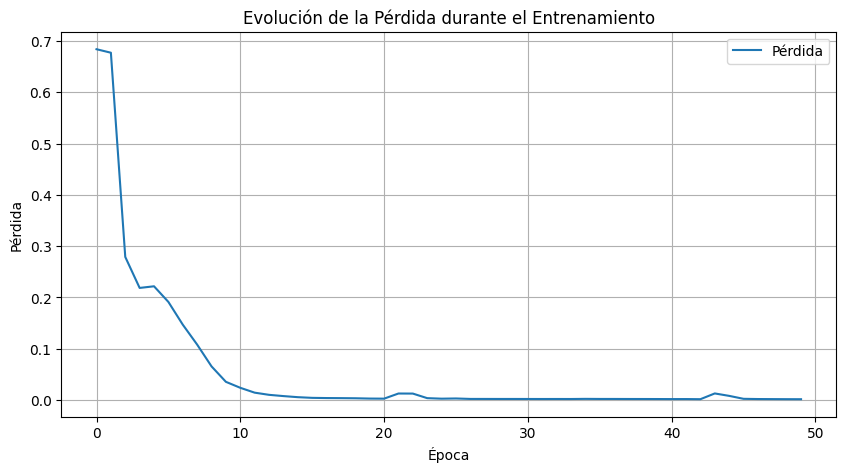

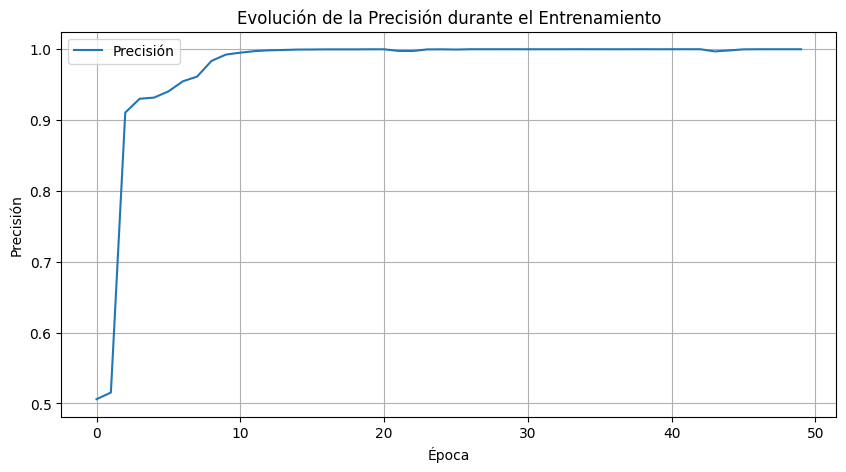

Reporte de Clasificación:
                   precision    recall  f1-score   support

No Acusatoria (0)       0.98      0.98      0.98       972
   Acusatoria (1)       0.21      0.21      0.21        29

         accuracy                           0.96      1001
        macro avg       0.60      0.59      0.59      1001
     weighted avg       0.95      0.96      0.95      1001

Matriz de Confusión:
[[950  22]
 [ 23   6]]
Matriz de Confusión en Porcentajes:
[[97.73662551  2.26337449]
 [79.31034483 20.68965517]]


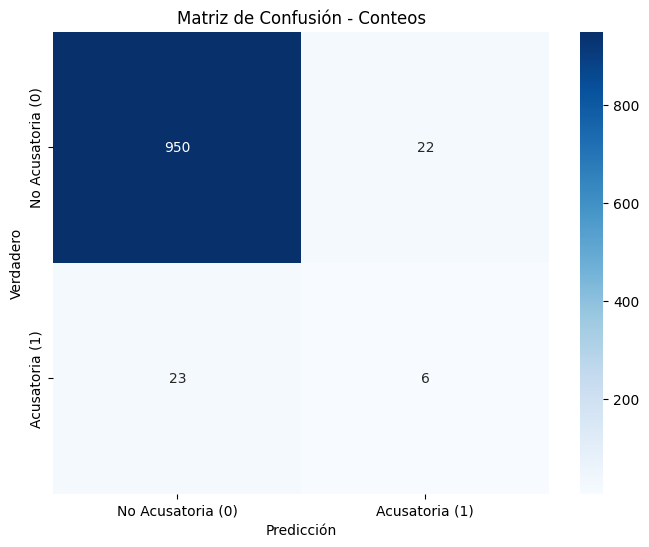

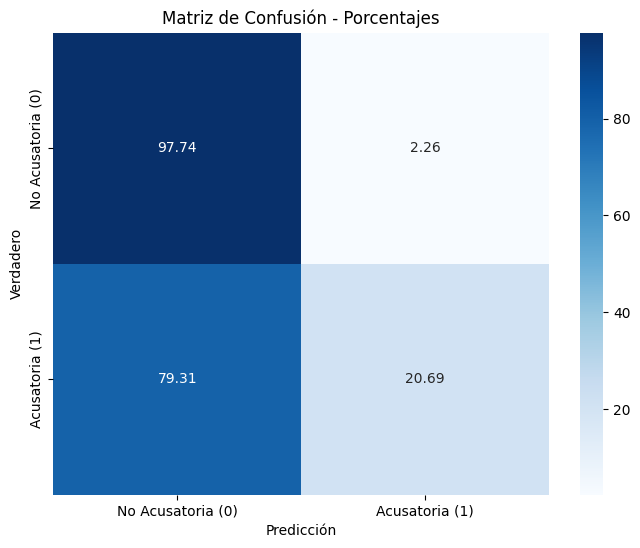

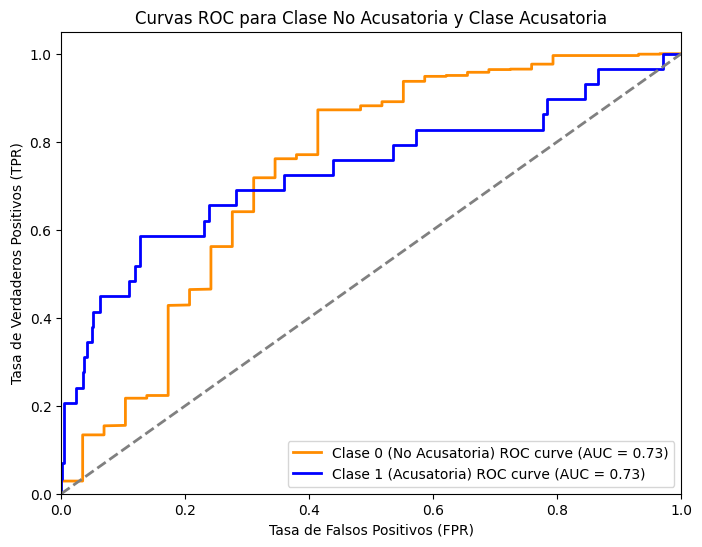

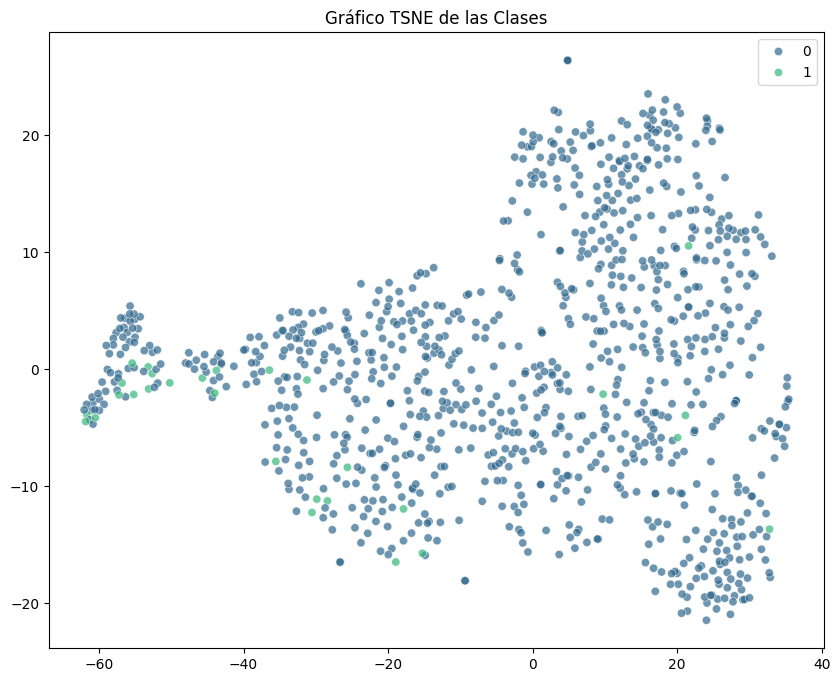

In [53]:
### GRU
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# Clase personalizada para el Dataset
class SentimentDataset(Dataset):
    def __init__(self, dataframe):
        self.inputs = dataframe['indexed_tokens'].tolist()
        self.labels = dataframe['final_pregunta_isAcusatoria'].tolist()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

# Función para rellenar secuencias en batch
def collate_fn(batch):
    inputs, labels = zip(*batch)
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    return inputs_padded, labels_tensor

# Crear datasets y DataLoaders
train_dataset = SentimentDataset(train_data)
test_dataset = SentimentDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)

import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy

# Definir la red GRU para el análisis de sentimientos
class SentimentGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SentimentGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        output = output[:, -1, :]  # Tomar la última salida de la secuencia
        return self.fc(output)

# Función para entrenar el modelo
def train_model(model, train_loader, optimizer, criterion, device, num_epochs):
    model.train()
    history_loss = []
    history_accuracy = []
    
    for epoch in range(num_epochs):
        total_loss = 0
        total_correct = 0
        total_examples = 0
        accuracy_metric = MulticlassAccuracy(num_classes=2, average='macro').to(device)

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            predictions = model(inputs)
            loss = criterion(predictions, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += accuracy_metric(predictions, labels)
            total_examples += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        avg_accuracy = total_correct / len(train_loader)
        history_loss.append(avg_loss)
        history_accuracy.append(avg_accuracy.item())

        print(f"Epoch {epoch+1}/{num_epochs}: Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}")

    return history_loss, history_accuracy

# Inicializar el modelo
vocab_size = len(vocab) + 1
model = SentimentGRU(vocab_size, embedding_dim=100, hidden_dim=128, output_dim=2)

# Mover el modelo a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir el optimizador y la función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Entrenar el modelo
num_epochs = 50
history_loss, history_accuracy = train_model(model, train_loader, optimizer, criterion, device, num_epochs)

# Graficar la pérdida a lo largo de las épocas
plt.figure(figsize=(10,5))
plt.plot(history_loss, label='Pérdida')
plt.title('Evolución de la Pérdida durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()
plt.show()

# Graficar la precisión a lo largo de las épocas
plt.figure(figsize=(10,5))
plt.plot(history_accuracy, label='Precisión')
plt.title('Evolución de la Precisión durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid()
plt.show()

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Definir la función para generar predicciones en el conjunto de prueba
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            _, predicted_labels = torch.max(predictions, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted_labels.cpu().numpy())
    
    return np.array(y_true), np.array(y_pred)

# Obtener las predicciones y etiquetas verdaderas
y_true, y_pred = evaluate_model(model, test_loader, device)

# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=['No Acusatoria (0)', 'Acusatoria (1)']))

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)

# Matriz de confusión en porcentajes
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
print("Matriz de Confusión en Porcentajes:")
print(conf_matrix_percent)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Acusatoria (0)', 'Acusatoria (1)'], yticklabels=['No Acusatoria (0)', 'Acusatoria (1)'])
plt.title('Matriz de Confusión - Conteos')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

# Graficar la matriz de confusión en porcentajes
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=['No Acusatoria (0)', 'Acusatoria (1)'], yticklabels=['No Acusatoria (0)', 'Acusatoria (1)'])
plt.title('Matriz de Confusión - Porcentajes')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

import torch
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Definir la función para generar predicciones en el conjunto de prueba y probabilidades
def evaluate_model(model, test_loader, device):
    model.eval()  # Poner el modelo en modo evaluación
    y_true = []
    y_pred_prob = []
    
    with torch.no_grad():  # No necesitamos calcular gradientes en modo evaluación
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)  # Obtener logits
            probabilities = torch.softmax(predictions, dim=1)  # Convertir logits en probabilidades
            y_pred_prob.extend(probabilities.cpu().numpy())  # Guardar las probabilidades para ambas clases
            y_true.extend(labels.cpu().numpy())  # Guardar las etiquetas verdaderas
    
    return np.array(y_true), np.array(y_pred_prob)

# Llama a la función para obtener etiquetas y probabilidades
y_true, y_pred_prob = evaluate_model(model, test_loader, device)

# A partir de aquí, y_pred_prob contiene las probabilidades de ambas clases

# Calcular la curva ROC para cada clase
fpr = {}
tpr = {}
roc_auc = {}

# Calcular ROC y AUC para la clase 0 (No Acusatoria)
fpr[0], tpr[0], _ = roc_curve(y_true, y_pred_prob[:, 0], pos_label=0)  # Probabilidades para la clase 0
roc_auc[0] = auc(fpr[0], tpr[0])

# Calcular ROC y AUC para la clase 1 (Acusatoria)
fpr[1], tpr[1], _ = roc_curve(y_true, y_pred_prob[:, 1], pos_label=1)  # Probabilidades para la clase 1
roc_auc[1] = auc(fpr[1], tpr[1])

# Graficar la curva ROC para ambas clases
plt.figure(figsize=(8, 6))

# Curva ROC para la clase 0 (No Acusatoria)
plt.plot(fpr[0], tpr[0], color='darkorange', lw=2, label='Clase 0 (No Acusatoria) ROC curve (AUC = %0.2f)' % roc_auc[0])

# Curva ROC para la clase 1 (Acusatoria)
plt.plot(fpr[1], tpr[1], color='blue', lw=2, label='Clase 1 (Acusatoria) ROC curve (AUC = %0.2f)' % roc_auc[1])

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Línea base
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC para Clase No Acusatoria y Clase Acusatoria')
plt.legend(loc="lower right")
plt.show()

# Modificar la función para extraer características
def extract_features(model, loader, device):
    model.eval()
    features = []
    labels = []
    
    with torch.no_grad():
        for inputs, label in loader:
            inputs = inputs.to(device)
            
            # Extraer embeddings a partir del RNN (no solo embeddings iniciales)
            outputs = model.embedding(inputs)  # Primero extraer el embedding
            rnn_output, _ = model.rnn(outputs)  # Pasar por la RNN
            
            # Tomar el promedio de los outputs a lo largo de la secuencia (dimensión 1)
            rnn_output_mean = torch.mean(rnn_output, dim=1)
            
            features.extend(rnn_output_mean.cpu().numpy())
            labels.extend(label.numpy())
    
    return np.array(features), np.array(labels)

# Extraer los embeddings del conjunto de prueba
features, labels = extract_features(model, test_loader, device)

# Aplicar TSNE para reducir las dimensiones a 2D
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features)

# Graficar TSNE
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette='viridis', legend='full', alpha=0.7)
plt.title('Gráfico TSNE de las Clases')
plt.show()
